In [2]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from scipy.optimize import fsolve, root
import scipy.special as sc
from scipy.special import erf, erfc
import pandas as pd

plt.style.use('science')

In [3]:
def int_gauss_xi(c):
    '''
    ∫dx exp(-0.5(x+c)^2) * x / sqrt(2pi) from -inf to 0 
    '''
    return -c - np.exp(-c**2 /2) / (np.sqrt(2*np.pi)) + 0.5 * c * erfc(c/np.sqrt(2))
    
def int_gauss_xi_sq(c):
    '''
    ∫dx exp(-0.5(x+c)^2) * x^2 / sqrt(2pi) from -inf to 0 
    '''
    return c * np.exp(-c**2/2)/(np.sqrt(2*np.pi)) + 0.5 * (1 + c**2) * (1 + erf(c/np.sqrt(2)))

In [4]:
def q_saddle(q0, k, kap, r, r0, lam0, lam1, psi0, psi1): 
    '''
    Saddle point function for q. i.e., f(q) = 0 implies ∂V(q) = 0 
    '''
    gauss_term = int_gauss_xi(kap + r*np.sqrt(k*q0)/(r0 * np.sqrt(psi0 - psi1)))
    return np.sqrt(lam0 - lam1)  + r*(lam0 - lam1) / (r0 *np.sqrt(k * (psi0 - psi1))) * gauss_term - np.sqrt(q0)
    
def cap(k, kap, r, r0, lam0, lam1, psi0, psi1, eps=1e-2):
    '''
    calculate the capacity for homog correlations
    '''
    q_sp = lambda q : q_saddle(q, k=k, kap=kap, r=r, r0=r0, lam0=lam0, lam1=lam1, psi0=psi0, psi1=psi1)
    init_q = (lam0 - lam1)
    qhat = fsolve(q_sp, init_q)
    c = r*np.sqrt(k*qhat) / (r0 * np.sqrt(psi0 - psi1)) + kap
    energy = k * (np.sqrt(qhat)/np.sqrt(lam0-lam1) - 1)**2 + int_gauss_xi_sq(c)
    return 1 / energy

In [5]:
def q_saddle(q0, k, kap, r, r0, lam0, lam1, psi0, psi1):
    eff_margin = (r * np.sqrt(k * (lam0-lam1) * q0) + kap)/(r0 * np.sqrt(psi0 - psi1))
    return 1 + r * np.sqrt(lam0-lam1) / (r0 * np.sqrt(k * (psi0 - psi1))) * int_gauss_xi(eff_margin) - np.sqrt(q0)

def cap(k, kap, r, r0, lam0, lam1, psi0, psi1):
    qsp = lambda q : q_saddle(q, k=k, kap=kap, r=r, r0=r0, lam0=lam0, lam1=lam1, psi0=psi0, psi1=psi1)
    init_q = 1 
    qhat = fsolve(qsp, init_q)
    eff_margin = (r * np.sqrt(k * (lam0-lam1) * qhat) + kap)/(r0 * np.sqrt(psi0 - psi1))
    energy = k * (np.sqrt(qhat) - 1)**2 + int_gauss_xi_sq(eff_margin)
    return 1 / energy

In [6]:
def make_indicators(row, base_psi1=0.85, base_lam1=0.7, base_r=0.5, base_r0=3.):
    '''
    Helper function for plotting the results of the 'ratios' experiment (plot b)
    Code which variable was solved for self-consistently by checking which variable deviates from the baseline
    Args: 
        - row: data frame row containing 'r0',  'lam1', 'r,' and 'psi1' columns 
        - base_{psi1, lam1, r,  r0}: default values of the four parameters.
    returns: integer code with information regarding the parameter which was solved for self-consistently
    '''
    p, l, r, r0 = row.psi1 != base_psi1, row.lam1 != base_lam1, row.r != base_r, row.r0 != base_r0
    assert p*1+l*1+r*1+r0*1 == 1 
    return 1 * p + 2 * l + 3 * r + 4 * r0

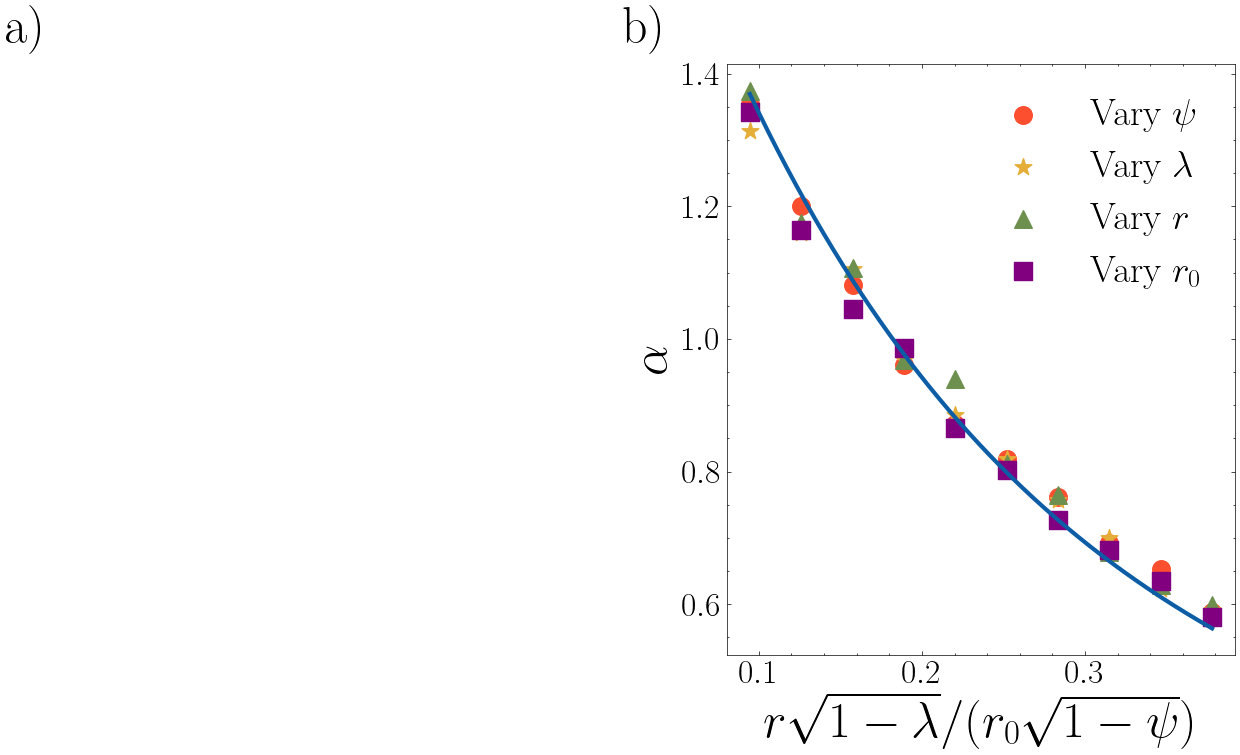

In [19]:
fig, ax = plt.subplot_mosaic([['a)', 'b)']],figsize=(12.5,7.75))
fn=36 #fontsize scaling
lw=3 # linewidth for theory line
s=160 # markersize
n_interp = 800 # num interpolation points

                    
r = pd.read_csv(os.getcwd() + '/results/spheres/ratio_sphere_simcap.csv')
r['ratio'] = r.r * np.sqrt(1-r.lam1)/(r.r0 * np.sqrt(1-r.psi1))
# average over experimental runs: 
r=r.groupby(['psi1', 'lam1', 'r', 'r0']).mean().reset_index()
# make a column signifying which parameter was solved for self-consistently
r['indicator']  = r.apply(make_indicators, axis=1)
colors = ['#fc4f30', '#e5ae38', '#6d904f', 'purple']
labels = [r'$\psi$', r'$\lambda$', r'$r$', r'$r_0$'] 
labels = ['Vary ' + l for l in labels]
markers = ['o', '*', '^', 's']
for i, (_, dat) in enumerate(r.groupby('indicator')): 
    ax['b)'].scatter(dat.ratio, dat.alpha, color=colors[i],  label = labels[i], s = s, marker=markers[i])

# calculate theoretical predictions by fixing lam=psi=0, r0=1, and varying the r parameter 
rads = np.linspace(r.ratio.min(), r.ratio.max(), n_interp)
ests = [cap(kap=0, k=7, r=r, r0=1, lam0=1, psi0=1, lam1=0, psi1=0) for r in rads]
ax['b)'].plot(rads, ests, lw=lw)
ax['b)'].set_xlabel(r'$r\sqrt{1-\lambda}/(r_0 \sqrt{1-\psi})$',fontsize=fn)
ax['b)'].set_ylabel(r'$\alpha$',fontsize=fn)
ax['b)'].tick_params(labelsize=fn*2/3)
ax['b)'].legend(fontsize = fn * 3/4)

ax['a)'].axis('off')

# add the labels
for label, a in ax.items():
    if label == 'bar)' : continue 
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    translation=-0.15
    a.text(translation, 1.0, label, transform=a.transAxes + trans,
            fontsize=fn, va='bottom')

plt.tight_layout()
plt.savefig(os.getcwd() + '/results/spheres/fig_4.eps', format='eps', dpi=300)